# Trajectory dataset preparation

This notebook contains some data-wrangling codes. The goal is to extract from the dataset, trajectories under suitable forms to perform FPCA and distribution learning.

# Preambles

In [2]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
# sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seig import eig as eig

from scipy.stats import norm
from scipy.stats import expon

%matplotlib inline

# Generate some data

Generate a lot of straight trajectories, where the slopes follow a uniform distribution:

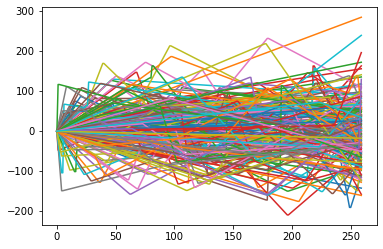

In [11]:
num_of_trajs = 200
length_of_traj = 260
y_trajs = np.zeros((num_of_trajs, length_of_traj))
# distribution of distance between anchor points
for i in range(num_of_trajs):
    t = 0
    while t < length_of_traj - 1:
        dist = int(np.round(expon.rvs(scale=1/2) * length_of_traj))
        if t + dist < length_of_traj:
            # this is a valid anchor point
            # sample the anchor value from a normal distribution
            anchor = norm.rvs(scale = 80)
            if dist < 2:
                dist = 2
            # print('Anchor is: {:.2f}'.format(anchor))
            if (t==0):
                y_trajs[i,t:t+dist] = 0 + np.arange(dist) / (dist - 1) * (anchor - 0)
            else:
                y_trajs[i,t:t+dist] = y_trajs[i,t-1] + np.arange(dist) / (dist - 1) * (anchor - y_trajs[i,t-1])
            t = t + dist
        else: # the last segment could be a bit longer
            dist = int(length_of_traj - t)
            anchor = norm.rvs(scale = 80)
            # print('Anchor is: {:.2f}'.format(anchor))
            if (t==0):
                y_trajs[i,t:t+dist] = 0 + np.arange(dist) / (dist - 1) * (anchor - 0)
            else:
                y_trajs[i,t:t+dist] = y_trajs[i,t-1] + np.arange(dist) / (dist - 1) * (anchor - y_trajs[i,t-1])
            t = t + dist

for i in range(num_of_trajs):
    plt.plot(y_trajs[i])

# Global FPCA decomposition for Y component

In [12]:
import sklearn
import skfda

%matplotlib inline

Convert the data to appropriate type for the skfda package

In [13]:
fdgry = skfda.FDataGrid(y_trajs, np.arange(y_trajs.shape[1]))
# here we don't use the container_t_np vector since we don't want it to mess up the unit

In [14]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

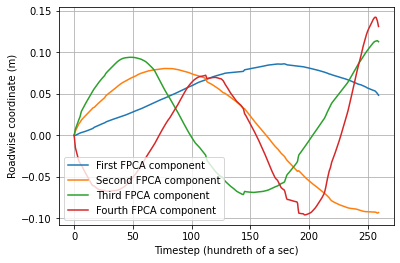

In [15]:
fpca_y = FPCA(n_components=4)
fpca_y.fit(fdgry)
fpca_y.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component'])
print('')

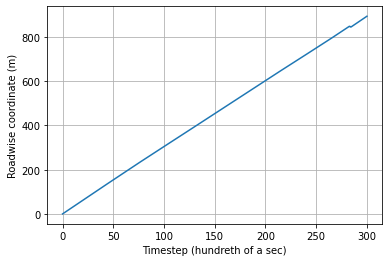

In [8]:
fpca_y.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_y = fpca_y.mean_.data_matrix.reshape((-1))

[0.89731514 0.07348648 0.02266406 0.00532613]


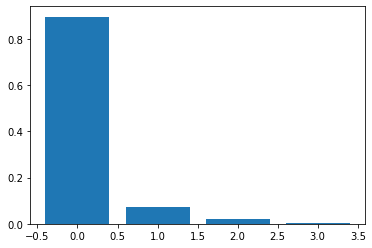

In [9]:
plt.bar(np.arange(4), fpca_y.explained_variance_ratio_)
print(fpca_y.explained_variance_ratio_)

# Global FPCA decomposition for X component

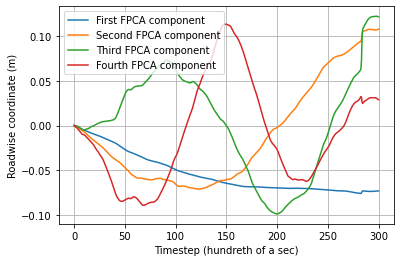

In [10]:
fpca_x = FPCA(n_components=4)
fpca_x.fit(fdgrx)
fpca_x.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component'])
print('')

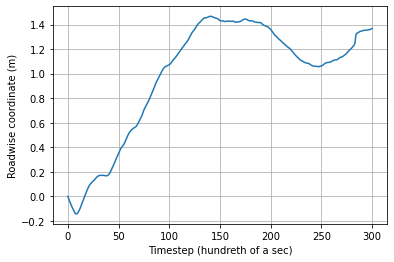

In [11]:
fpca_x.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_x = fpca_x.mean_.data_matrix.reshape((-1))

[0.91929363 0.04625759 0.01301754 0.00650374]


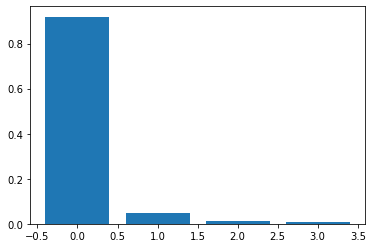

In [12]:
plt.bar(np.arange(4), fpca_x.explained_variance_ratio_)
print(fpca_x.explained_variance_ratio_)

# Zero-meaned trajectories

This might be helpful in analytically finding the basis for the trajectory (which we are suspicious that it is a Fourier basis).

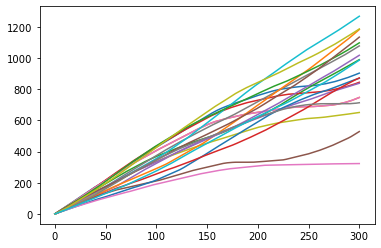

In [13]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i]
    plt.plot(traj_to_plot)

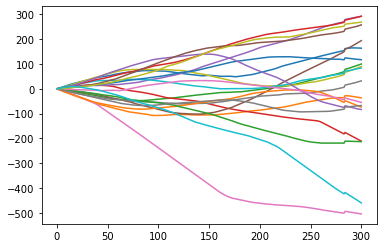

In [14]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y
    plt.plot(traj_to_plot)
